# Pedestrian Analysis
# on Linked Data: Crash (MV104) + Hospital (SPARCS)

Analysis Part 1: Severity Ratio

In [1]:
import pandas as pd
pd.options.display.max_rows = 130
pd.options.display.max_columns = 130

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import analysis as an

import sys
sys.path.insert(0, '../2-Data/')
import databuild as db

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Pedestrian/Bicyclist Data
The MV104 crash database is compiled by DMV into three tables: 
* crash table 
* person table
* vehicle table 

The databuild.py script reads in the tables and organizes them into a person level table for pedestrians or bicyclists involved in 1-vehicle crashes.

The script also reads in the linked hospital-crash data from DOHMH and adds the hospital info (e.g. the person's b-ISS score) onto the ped file.

The resulting dataframe (ped) is what the rest of the analyis in this notebook uses. It only includes injured people who were able to be linked to hopital data by DOHMH.

In [2]:
# read in DMV data into 3 tables
crash,ind,veh = db.readDMV()

# reorganize into pedestrian/bicyclist 1-veh crashes
ped = db.buildTablesDMV(crash,ind,veh)

#read in DMV-SPARCS linked data
linked = db.readLinked()

# included biss data from linked onto ped (dropping anything not in linked)
ped = db.mergeBiss(ped,linked)

#format and categorize variables
ped = db.formatVars(ped)

print 'linked ped',ped.shape

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


full crash table (522108, 26)
full person table (1502797, 22)
full vehicle table (1092922, 20)


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,9,20,25,35,48,54,58,63,65,85,89,102,126,128,129,138) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


pedestrians/bicyclists (police reported) (single vehicle) (95292, 80)
linked (76763, 131)
linked after dropping no police reports (69657, 131)
linked ped (17624, 106)


## Defining Severe

Patients with a derived Injury Severity Score (b-ISS) of 9 or greater we defined as a severe case. While generally the bar is set at ISS 16 or greater (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3217501/ ), we chose a lower threshold to take into account injuries such as a broken leg (ISS = 9) which may be low on a threat to life scale but can have significant impact on a person’s ability to work and get around in the near term. 

We could have chosen to do an analysis without assigning a threshold (for instance using an AUC measure), however most implementations would necessitate defining a threshold at some point.


## Severity Ratio

We use the Severity Ratio to understand which crash attributes are associated with a severe outcome. The Severity Ratio (SR) is defined as the probability of a severe injury outcome given an attribute was present divided by the probability of a severe injury outcome (irrespective of whether the attribute is present or not). (Note: this is slightly different from the usual definition of Risk Ratio where the denominator is probability of a severe outcome given the attribute is NOT present).

$$ SR = \frac{P( severe \space | \space attribute )}{P(severe)} $$

If SR is much greater than 1 then having the attribute present indicates those types of crashes have a higher likelihood of a severe outcome. If SR is close to 1 then that attribute is not anymore indiciative of severity than a random crash.

The denominator of SR is calculated in the next cell (around .10 for pedestrians/bicyclists)

In [3]:
# baseline severity -- this is the denominator of the SR
pedNumSev = ped[ped.biss_severity_9=='severe'].shape[0]
pedNum = ped.shape[0]
pedPctSev = pedNumSev/float(pedNum)*100
print 'percent of ped with severe outcomes',pedPctSev

percent of ped with severe outcomes 9.69133000454


In [13]:
factorSev = an.sratio(data=ped)
factorSev.sort_values('SeverityRatio',ascending=False)

,SevereCount,AllCount,SeverePct,SeverityRatio
AgeDecade : 90.0,21,44,0.477273,4.924739
InjuryStatus : Not Conscious States,417,935,0.445989,4.601941
InjuryType : Severe Bleeding,234,532,0.439850,4.538589
InjuryType : Internal,90,269,0.334572,3.452287
InjuryType : Amputation,9,27,0.333333,3.439500
AgeDecade : 80.0,110,373,0.294906,3.042990
InjuryType : Concussion,72,263,0.273764,2.824837
InjuryLoc : Eye,6,23,0.260870,2.691783
Age70 : age >= 70,308,1224,0.251634,2.596486
OtherVehTypeVIN : Truck,34,141,0.241135,2.488149


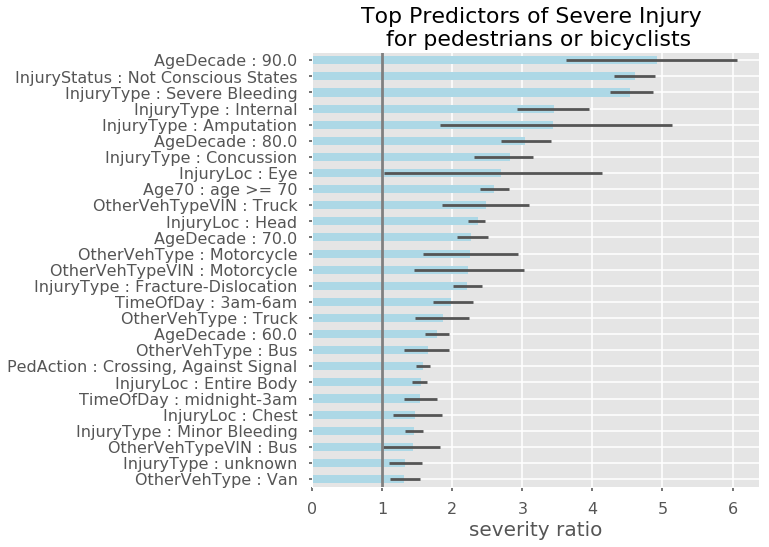

In [5]:
samples = an.bootstrapSR(ped,N=100)
an.plotSR(factorSev,samples)

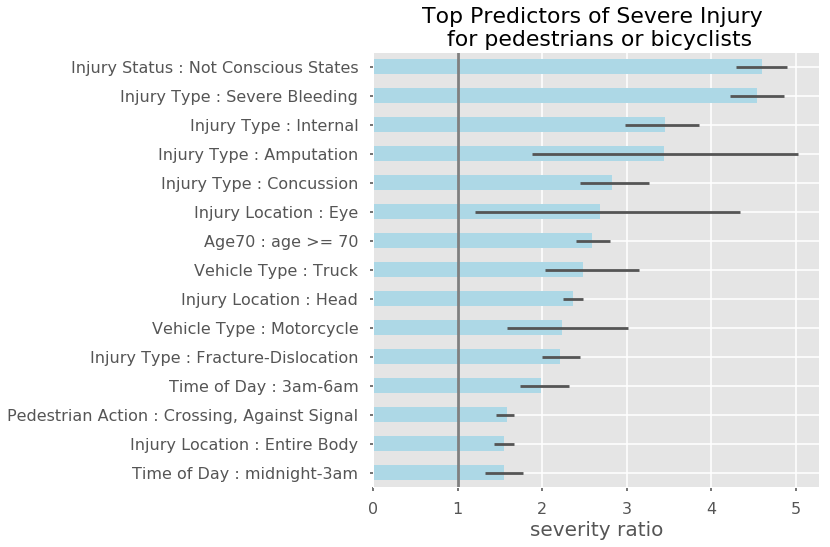

In [6]:
#clean up the graph, get rid of age by decades and the redundant VIN vehicle type

# drop age decades
ped_df = ped.drop(ped.filter(like='Decade').columns,axis=1)
# drop vehicle types coming from VIN (redundant)
ped_df = ped_df.drop('f_OtherVehType',axis=1)

factorSev = an.renameLabelSR(an.sratio(ped_df))
samples = an.renameLabelSR(an.bootstrapSR(ped_df,N=100))

an.plotSR(factorSev,samples,minSR=1.5)

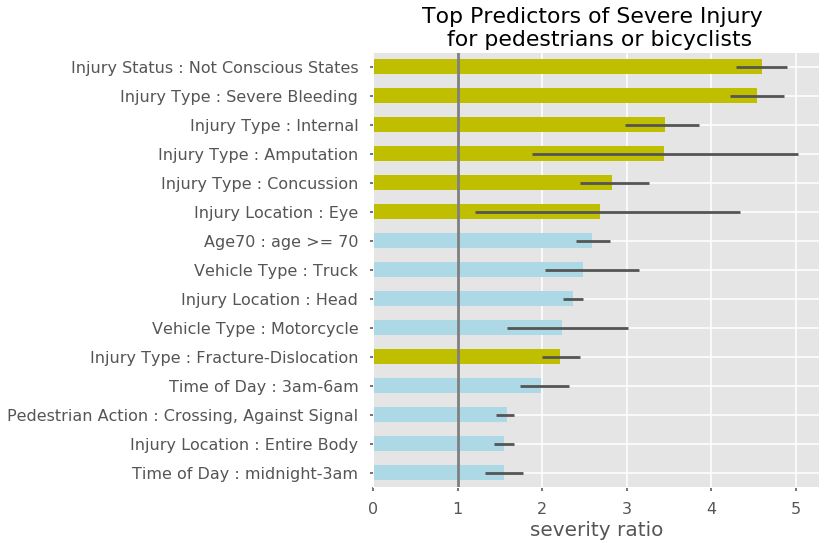

In [7]:
# redo graph with yellow bars for K,A injuries from KABCO
an.plotSR(factorSev,samples,minSR=1.5,
       colors=['lightblue']*4+['y']+['lightblue']*4+['y']*6)

In [8]:
# show above in table format

errmax = samples.quantile(.95, axis =  1)
errmin = samples.quantile(.05, axis =  1)

output = pd.DataFrame()
output['max'] = errmax[factorSev.SeverityRatio>1.5]
output['min'] = errmin[factorSev.SeverityRatio>1.5]
output['mid'] = factorSev[factorSev.SeverityRatio>1.5].SeverityRatio

output.sort_values('mid',ascending=False)

,max,min,mid
Injury Status : Not Conscious States,4.901997,4.295233,4.601941
Injury Type : Severe Bleeding,4.868213,4.222310,4.538589
Injury Type : Internal,3.862953,2.985556,3.452287
Injury Type : Amputation,5.031100,1.880770,3.439500
Injury Type : Concussion,3.269523,2.443518,2.824837
Injury Location : Eye,4.340343,1.201093,2.691783
Age70 : age >= 70,2.809461,2.400650,2.596486
Vehicle Type : Truck,3.151897,2.029730,2.488149
Injury Location : Head,2.485255,2.251381,2.364495
Vehicle Type : Motorcycle,3.018137,1.583859,2.231027


### age distribution
Let's extract only the pedestrian age and see the distribution.

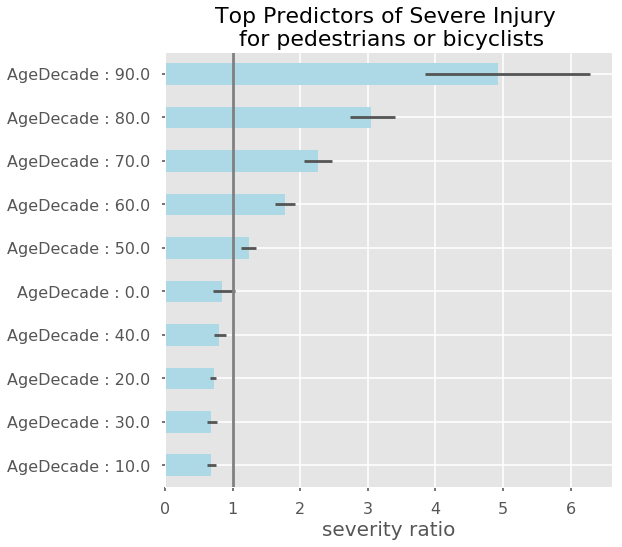

In [31]:
ageSev = factorSev.T.filter(regex='^AgeDecade').T
samples = an.bootstrapSR(ped,N=100)
ageSevSamples = samples.T.filter(regex='^AgeDecade').T
an.plotSR(ageSev,ageSevSamples,minSR=0)

Exclude elderly to see if there are any differences

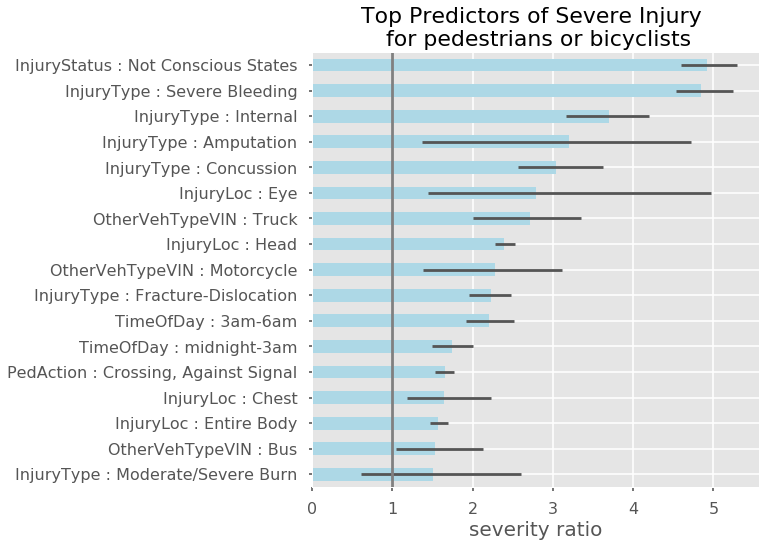

In [9]:
# Pedestrians under age 70
pedNotOld = ped_df[ped_df.f_AgeYear<70]
factorSevNotOld = an.sratio(pedNotOld)
samples = an.bootstrapSR(pedNotOld,N=100)
an.plotSR(factorSevNotOld,samples,minSR=1.5)

In [10]:
# number of cases with peds under 70 and a severe outcome
pedNotOld[pedNotOld.biss_severity_9=='severe'].shape

(1400, 103)

In [11]:
# fraction of severe outcomes for peds under 70
pedNotOld[pedNotOld.biss_severity_9=='severe'].shape[0]/float(pedNotOld.shape[0])

0.08536585365853659